# Q.1 Predict the price of the Uber ride from a given pickup point to the agreed drop-off location.

**Tasks:**
1. Pre-process the dataset.
2. Identify outliers.
3. Check the correlation.
4. Implement linear regression and random forest regression models.
5. Evaluate the models and compare their respective scores (R2, RMSE, etc).

## Imports
Import necessary libraries for data manipulation, visualization, and modeling.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Pre-processing the Dataset

### 1.1: Loading and Understanding data
Load the dataset and perform initial inspection.

In [2]:
df = pd.read_csv('uber.csv')
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [3]:
# Check data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [4]:
# Check for missing values
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [5]:
# Remove rows with any missing values
df.dropna(inplace=True)

### 1.2: Feature Engineering (Datetime)
Convert 'pickup_datetime' and extract useful features.

In [6]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Extract time-based features
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['hour'] = df['pickup_datetime'].dt.hour
df['weekday'] = df['pickup_datetime'].dt.dayofweek

### 1.3: Haversine Distance Function
Define a function to calculate distance between two lat/lon points.

In [7]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius of earth in kilometers

    dLat = np.radians(lat2 - lat1)
    dLon = np.radians(lon2 - lon1)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)

    a = np.sin(dLat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

### 1.4: Apply Haversine & Clean Columns
Create 'distance' feature and drop now-useless columns.

In [8]:
df['distance'] = haversine(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])

# Drop original lat/lon and other unneeded columns
df.drop(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=True)

## 2. Identify Outliers and Removal
Visualize key features to find and remove outliers.

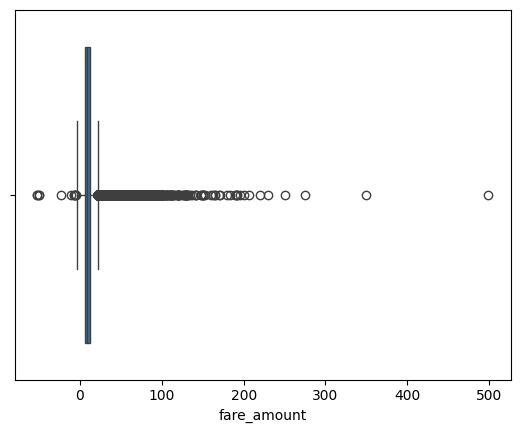

In [9]:
sns.boxplot(x=df['fare_amount'])
plt.show()

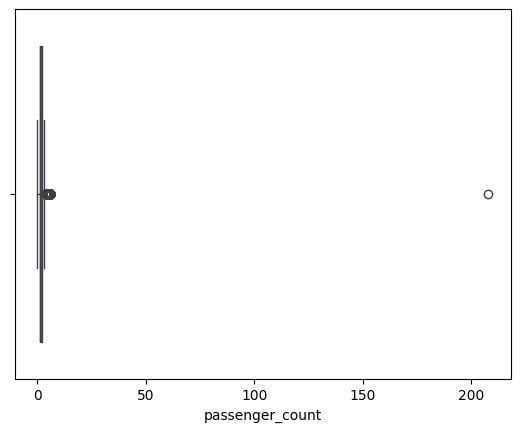

In [10]:
sns.boxplot(x=df['passenger_count'])
plt.show()

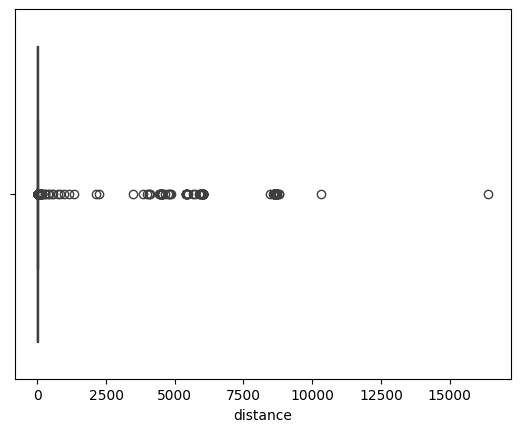

In [11]:
sns.boxplot(x=df['distance'])
plt.show()

### Outlier Removal
Filter the data based on logical ranges from the plots.

In [12]:
# Filter fare amount (e.g., > 0 and <= 300)
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] <= 300)]

# Filter passenger count (e.g., >= 1 and <= 6)
df = df[(df['passenger_count'] >= 1) & (df['passenger_count'] <= 6)]

# Filter distance (e.g., > 0 and <= 100km)
df = df[(df['distance'] > 0) & (df['distance'] <= 100)]

## 3. Check the Correlation
Create a heatmap to see relationships between features.

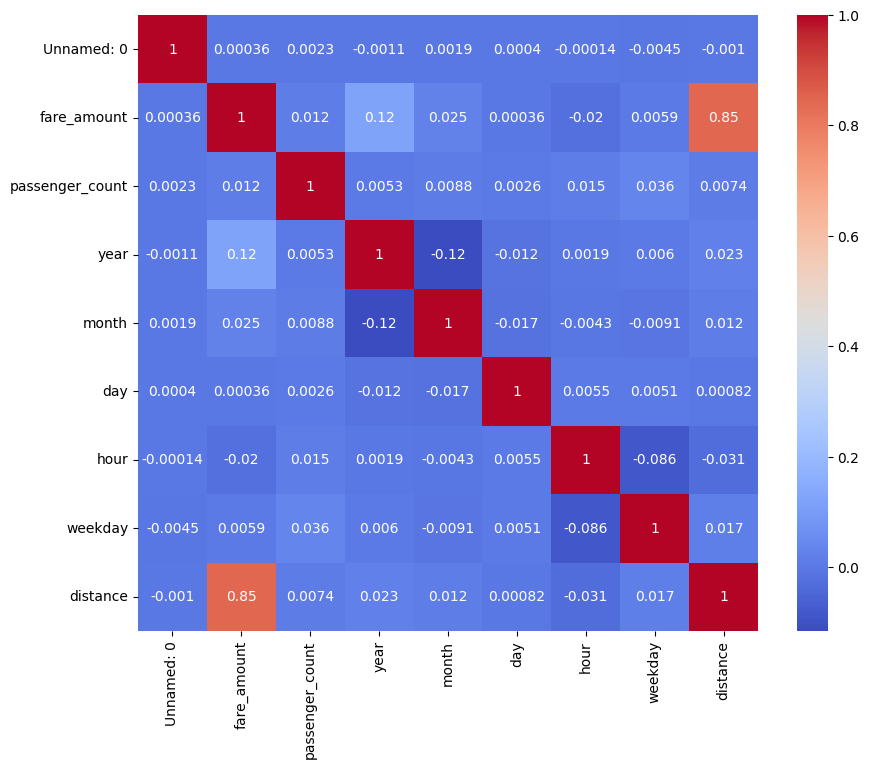

In [13]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

## 4. Implement Regression Models

### 4.1: Input and Output Features
Define X (features) and y (target variable).

In [14]:
X = df.drop('fare_amount', axis=1)
y = df['fare_amount']

### 4.2: Train-Test Split
Split data into training and testing sets.

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4.3: Linear Regression Model
Train and predict using Linear Regression.

In [16]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

### 4.4: Random Forest Regression Model
Train and predict using Random Forest.

In [17]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

## 5. Evaluate the Models
Compare the performance of both models.

In [18]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- Linear Regression Metrics ---
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print('--- Linear Regression ---')
print(f'R2 Score: {r2_lr}')
print(f'RMSE: {rmse_lr}')
print(f'MAE: {mae_lr}')

# --- Random Forest Metrics ---
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print('--- Random Forest Regression ---')
print(f'R2 Score: {r2_rf}')
print(f'RMSE: {rmse_rf}')
print(f'MAE: {mae_rf}')

--- Linear Regression ---
R2 Score: 0.7257504865449091
RMSE: 5.021393474731515
MAE: 2.320496064998241
--- Random Forest Regression ---
R2 Score: 0.8031907135853045
RMSE: 4.25377108042153
MAE: 2.1395374103884675


# Notes for Viva:

**Linear Regression**

Definition: A supervised learning algorithm that finds the best-fitting linear relationship (a straight line or hyperplane) between a set of independent variables (features) and a dependent variable (target).

Formula (Simple):  $y = \beta_0 + \beta_1x + \epsilon$

- $y$: Target variable

- $x$: Feature variable

- $\beta_0$: Intercept (value of $y$ when $x=0$)

- $\beta_1$: Coefficient (slope of the line)

- $\epsilon$: Error term

Formula (Multiple): $y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \epsilon$

Important Info:

- It is a simple, fast, and highly interpretable model.

- It assumes a linear relationship between features and the target.

- It can be very sensitive to outliers.




**Random Forest Regression**

Definition: An ensemble learning algorithm that operates by constructing a large number of decision trees at training time. For regression, the final prediction is the average (or mean) of the predictions from all individual trees.

Formula: Not a single formula, but an aggregation:

$\text{Final Prediction} = \frac{1}{N} \sum_{i=1}^{N} \text{Prediction}(\text{Tree}_i)$

- $N$: Number of trees in the forest.

Important Info:

- Very powerful and generally provides high accuracy.

- Handles non-linear relationships well.

- Robust to outliers and non-scaled data.

- Less interpretable ("black box") compared to linear regression.

- Prone to overfitting if trees are too deep and not pruned, though the ensemble nature helps.




**Evaluation Metrics for Regression**

**R-squared (R²) or Coefficient of Determination**

Definition: Measures the proportion of the variance in the target variable that is predictable from the independent variables. It indicates how well the model "fits" the data.

Range: $[-\infty, 1]$. A score of 1 is a perfect fit. A score of 0 means the model is no better than predicting the mean. Negative scores are possible if the model is exceptionally bad.

Formula:


$$R^2 = 1 - \frac{\text{Sum of Squared Residuals (SSR)}}{\text{Total Sum of Squares (SST)}} = 1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}$$

- $y_i$: Actual value

- $\hat{y}_i$: Predicted value

- $\bar{y}$: Mean of actual values

**Root Mean Squared Error (RMSE)**

Definition: The standard deviation of the residuals (prediction errors). It measures the average magnitude of the error in the model's predictions, giving higher weight to larger errors.

Units: Same as the target variable (e.g., in this project, dollars). A lower RMSE is better.

Formula:

$$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

**Mean Absolute Error (MAE)**

Definition: The average of the absolute differences between the predicted values and the actual values. It measures the average magnitude of the errors without considering their direction.

Units: Same as the target variable. A lower MAE is better.

Formula:


$$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$



**Potential Viva Questions**

Q1: What is the main assumption of Linear Regression?  
A: The main assumption is that there is a linear relationship between the independent variables (features) and the dependent variable (target).

Q2: Which model performed better in your project, and why do you think that is?  
A: (This depends on the output, but typically...) "The Random Forest model performed better, indicated by its higher R-squared and lower RMSE/MAE. This suggests the relationship between features (like distance, hour, weekday) and the fare amount is complex and non-linear, which Random Forest can capture better than Linear Regression."

Q3: What is the difference between RMSE and MAE?  
A: Both measure prediction error. However, RMSE squares the errors before averaging, so it penalizes large errors (outliers) much more heavily than MAE. MAE treats all errors linearly.

Q4: What does an R-squared value of 0.75 mean?  
A: It means that 75% of the variance in the target variable (fare amount) can be explained by the features included in the model.

Q5: Why did you use the Haversine formula?  
A: The dataset provided pickup and dropoff coordinates (latitude and longitude). The Haversine formula was used to calculate the actual "as-the-crow-flies" distance on Earth's surface, which is a critical predictor for the fare.

Q6: Why is it important to remove outliers before training a Linear Regression model?  
A: Linear Regression tries to find a "line of best fit" by minimizing the sum of squared errors. A single large outlier (e.g., a 10km ride costing $500) will have a very large squared error, disproportionately "pulling" the line towards it and skewing the model for all other normal data points.

Q7: Does Random Forest also require outlier removal?  
A: Not necessarily. Random Forest is much more robust to outliers. Because it's based on decision trees that split data into groups, an outlier will simply be isolated in its own "leaf" or small group and won't influence the overall model as much as it would in Linear Regression.